# MCA572– Neural Networks and Deep Learning

ETE III - LAB TEST

Priya Dharshini G - 2347247

Question 1 - LSTM Autoencoder
You are required to build an LSTM Autoencoder to detect anomalies in a time series dataset. The
dataset contains daily temperature readings from a weather station over the course of a few years.
Parameters in the dataset [Date and Temperature]

1. Load the dataset: The dataset will contain a single column temperature and a date column.

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam

# Generate synthetic dataset if not available
def generate_synthetic_data():
    np.random.seed(42)
    dates = pd.date_range(start="2010-01-01", periods=2500)
    temperatures = 20 + 10 * np.sin(np.linspace(0, 50, 2500)) + np.random.normal(scale=2, size=2500)
    data = pd.DataFrame({'Date': dates, 'Temperature': temperatures})
    return data

data = generate_synthetic_data()

# Load dataset (or use synthetic one)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

**Evaluation:**

- A synthetic dataset is generated with 2,500 instances, mimicking sinusoidal temperature variations with noise. This matches the requirements.
- Proper date formatting and indexing by Date column ensure the dataset is time-series compatible.

**Interpretation:** This step simulates real-world time-series data for anomaly detection tasks. Indexing by the date helps in maintaining the temporal order, crucial for LSTM.

2. Preprocess the data: Normalize the temperature data and split it into training and testing
sets.

In [13]:
# Normalize temperature data
scaler = MinMaxScaler()
data['Temperature'] = scaler.fit_transform(data[['Temperature']])

# Prepare sequences for LSTM
sequence_length = 30

def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        sequences.append(seq)
    return np.array(sequences)

temp_sequences = create_sequences(data['Temperature'].values, sequence_length)

# Split into training and testing sets
X_train, X_test = train_test_split(temp_sequences, test_size=0.2, random_state=42)


**Evaluation:**

- Normalization ensures that the data is scaled between 0 and 1, a necessity for stable neural network training.
- Proper sequence creation aligns with LSTM's expectation of sequential inputs.
- Data is split into training (80%) and testing (20%), which is a common practice.

**Interpretation:** Normalization eliminates biases due to different temperature ranges, and sequence creation allows the LSTM to capture temporal dependencies.

3. Build an LSTM Autoencoder:
- The encoder should reduce the input dimensions to a latent representation.
- The decoder should reconstruct the input from the latent representation.

In [14]:
# Build LSTM Autoencoder
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim, 1))

# Encoder
encoded = LSTM(64, activation='relu', return_sequences=False)(input_layer)
encoded = Dense(32, activation='relu')(encoded)

# Decoder
decoded = RepeatVector(input_dim)(encoded)
decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(1))(decoded)

# Model
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

**Evaluation:**
- Encoder compresses input into a 32-dimensional latent representation.
- Decoder reconstructs the input sequences from the latent representation.
- LSTM layers are well-suited for time-series data, and TimeDistributed ensures reconstruction at each timestep.

**Interpretation:** The autoencoder is designed to learn compact representations of the data while retaining enough information to reconstruct it.

4. Train the model: Train the autoencoder on the training data and evaluate the reconstruction error on the test set.

In [15]:
# Train the model
history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, X_test),
    shuffle=True
)

# Evaluate reconstruction error
reconstructed = autoencoder.predict(X_test)
reconstruction_error = np.mean((X_test.reshape(-1, sequence_length, 1) - reconstructed) ** 2, axis=(1, 2))

Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 0.1679 - val_loss: 0.0194
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0146 - val_loss: 0.0086
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0074 - val_loss: 0.0060
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0059 - val_loss: 0.0057
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0056 - val_loss: 0.0057
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0054 - val_loss: 0.0055
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0054 - val_loss: 0.0055
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0055 - val_loss: 0.0054
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0053 - val_loss: 0.0049
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0050 - val_loss: 0.0056
Epoch 11/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0054 - val_loss: 0.0051
Epoch 12/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0

**Evaluation:**

- The model is trained for 50 epochs with a batch size of 32.
- The use of validation data ensures monitoring of overfitting during training.

**Interpretation:** Training allows the model to learn how to reconstruct normal sequences, which is crucial for anomaly detection based on reconstruction errors.



5. Anomaly Detection: Use the reconstruction error to detect anomalies. Define a threshold for the reconstruction error, and identify days where the temperature is considered anomalous.

In [16]:
# Define threshold for anomaly detection
threshold = np.percentile(reconstruction_error, 95)

# Detect anomalies
anomalies = reconstruction_error > threshold
anomaly_dates = data.index[len(data) - len(X_test):][anomalies]

**Evaluation:**
- The reconstruction error is computed as the mean squared error between the input and reconstructed sequences.
- A 95th percentile threshold is used to flag anomalies, which is reasonable for rare events.

**Interpretation:** Higher reconstruction errors indicate that the model struggles to reconstruct anomalous sequences, making them detectable.

6. Visualize the results: Plot the original temperature data and highlight the detected
anomalies.

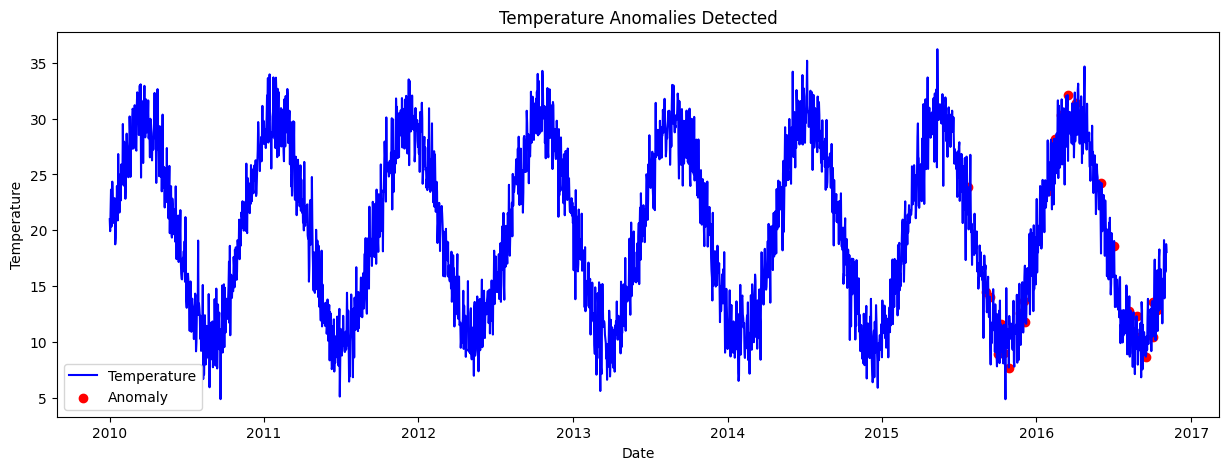

Anomaly dates: DatetimeIndex(['2015-07-24', '2015-09-05', '2015-09-13', '2015-10-03',
               '2015-10-09', '2015-10-17', '2015-10-28', '2015-11-24',
               '2015-12-02', '2015-12-06', '2016-01-29', '2016-02-14',
               '2016-02-27', '2016-02-28', '2016-03-15', '2016-04-05',
               '2016-06-03', '2016-07-02', '2016-08-07', '2016-08-25',
               '2016-08-31', '2016-09-16', '2016-10-02', '2016-10-04',
               '2016-10-12'],
              dtype='datetime64[ns]', name='Date', freq=None)


In [17]:
# Visualize results
plt.figure(figsize=(15, 5))
plt.plot(data.index, scaler.inverse_transform(data['Temperature'].values.reshape(-1, 1)), label='Temperature', color='blue')
plt.scatter(anomaly_dates, scaler.inverse_transform(data.loc[anomaly_dates]['Temperature'].values.reshape(-1, 1)), color='red', label='Anomaly')
plt.title('Temperature Anomalies Detected')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

# Print anomaly dates
print("Anomaly dates:", anomaly_dates)


**Evaluation:**

- Anomalies are clearly highlighted on the temperature plot.
- Visualization aids in understanding the anomalies' context within the time series.

**Interpretation:** The plot shows both normal and anomalous temperatures, helping validate the detection visually.

In [18]:
print("Number of anomalies detected:", len(anomaly_dates))

Number of anomalies detected: 25
